In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import itertools
import scipy.stats
from scipy.spatial import distance
import collections

In [2]:
pred_results = pd.read_csv('prediction_results.csv')
pred_results

,Canonical_SMILES,predicted,glob_vector
0,CCCCCCCCC=CCCCCCCCC(=O)OC,57.968250,2.691359 14.592577 -9.436016 -5.058426 3.00275...
1,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O,32.391770,1.516830 8.199538 -5.012877 -3.377009 1.524693...
2,CCCCC1CCCC2CCCCC12,29.558363,1.745942 7.646198 -4.469604 -2.352664 1.533207...
3,C=CC(C)=CCC=C(C)C,28.981422,1.265745 7.677176 -4.606571 -2.230392 1.572281...
4,CCCCCCCC(=O)OCC,41.965748,1.682150 10.854991 -6.497654 -3.748829 2.38611...
...,...,...,...
625,CCCCCCCCCCCCCCCCCC(=O)O,70.268486,4.218514 18.318501 -10.543983 -6.405914 4.1426...
626,CCCCCCCCCCCCCCCCc1cc(C)cc(C)c1C,38.849712,2.940196 9.780895 -6.842910 -3.857143 3.013691...
627,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC,46.116287,1.885478 14.634891 -7.869593 -3.706098 2.03854...
628,CCCc1ccc2c(c1)CCCC2,7.196461,0.202410 1.829507 -1.479237 -0.212674 0.350839...


In [3]:
glob_vecs = []
for item in pred_results['glob_vector']:
    glob_vecs.append(item.split(' '))
pred_results['glob_vecs'] = glob_vecs

pred_results = pred_results.drop(['glob_vector'], axis=1)

In [4]:
pred_results

,Canonical_SMILES,predicted,glob_vecs
0,CCCCCCCCC=CCCCCCCCC(=O)OC,57.968250,"[2.691359, 14.592577, -9.436016, -5.058426, 3...."
1,CCCCC/C=C\C/C=C\CCCCCCCC(=O)O,32.391770,"[1.516830, 8.199538, -5.012877, -3.377009, 1.5..."
2,CCCCC1CCCC2CCCCC12,29.558363,"[1.745942, 7.646198, -4.469604, -2.352664, 1.5..."
3,C=CC(C)=CCC=C(C)C,28.981422,"[1.265745, 7.677176, -4.606571, -2.230392, 1.5..."
4,CCCCCCCC(=O)OCC,41.965748,"[1.682150, 10.854991, -6.497654, -3.748829, 2...."
...,...,...,...
625,CCCCCCCCCCCCCCCCCC(=O)O,70.268486,"[4.218514, 18.318501, -10.543983, -6.405914, 4..."
626,CCCCCCCCCCCCCCCCc1cc(C)cc(C)c1C,38.849712,"[2.940196, 9.780895, -6.842910, -3.857143, 3.0..."
627,CCCCCCOC(=O)c1ccccc1C(=O)OCCCCCC,46.116287,"[1.885478, 14.634891, -7.869593, -3.706098, 2...."
628,CCCc1ccc2c(c1)CCCC2,7.196461,"[0.202410, 1.829507, -1.479237, -0.212674, 0.3..."


In [192]:
pred_no_dup = pred_results.drop_duplicates(subset=['Canonical_SMILES'])
X = np.array([np.array(xi) for xi in (pred_no_dup['glob_vecs'])])
np.shape(X)

(629, 64)

In [193]:
from sklearn import random_projection
transformer = random_projection.SparseRandomProjection(n_components = 2)
X_new = transformer.fit_transform(X)

X_new.shape

/home/sabari/.conda/envs/rdkit/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
/home/sabari/.conda/envs/rdkit/lib/python3.7/site-packages/sklearn/utils/validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


(629, 2)

Lets try tSNE. First, let's determine the learning rate and perplexity to use. Color the oxygenates (H bond donor/acceptor red, the hydrocarbons green.

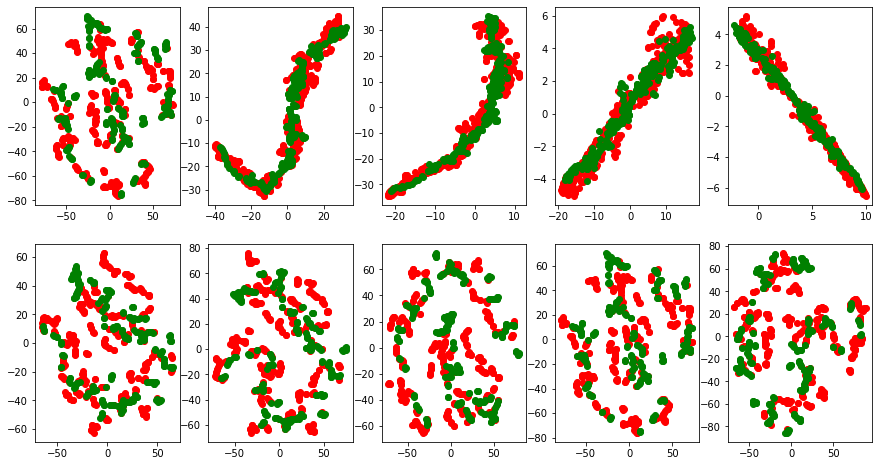

In [203]:
from sklearn import manifold
import matplotlib.pyplot as plt

float_vecs = []
preds = pred_results['predicted']
for vec in pred_results['glob_vecs']:
    float_vec = [float(x) for x in vec]
    float_vecs.append(float_vec)
    
n_samples = len(preds)

(fig, subplots) = plt.subplots(2, 5, figsize=(15, 8))

perplexities = [5, 30, 50, 100, 200]
learning_rates = [10, 50, 100, 200, 500]

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]

    tsne = manifold.TSNE(
        n_components = 2,
        init = "random",
        random_state = 0,
        perplexity = perplexity,
        learning_rate = 200.0,
        n_iter=1000)

    Y = tsne.fit_transform(float_vecs)
   
    y_true = np.array([item for item, mask in zip(Y, h_acc_true) if mask])
    y_false = np.array([item for item, mask in zip(Y, h_acc_true) if not mask])
    ax.scatter(y_true[:, 0], y_true[:, 1], c = 'r')
    ax.scatter(y_false[:, 0], y_false[:, 1], c = 'g')

    
for i, learning_rate in enumerate(learning_rates):
    ax = subplots[1][i]

    tsne = manifold.TSNE(
        n_components = 2,
        init = "random",
        random_state = 0,
        perplexity = 5,
        learning_rate = learning_rate,
        n_iter=1000)

    Y = tsne.fit_transform(float_vecs)
    
    y_true = np.array([item for item, mask in zip(Y, oxygenates) if mask])
    y_false = np.array([item for item, mask in zip(Y, oxygenates) if not mask])
    ax.scatter(y_true[:, 0], y_true[:, 1], c = 'r')
    ax.scatter(y_false[:, 0], y_false[:, 1], c = 'g')

Same as above, but color based on cetane number. Use the default color map - lowest -> highest : purple -> yellow

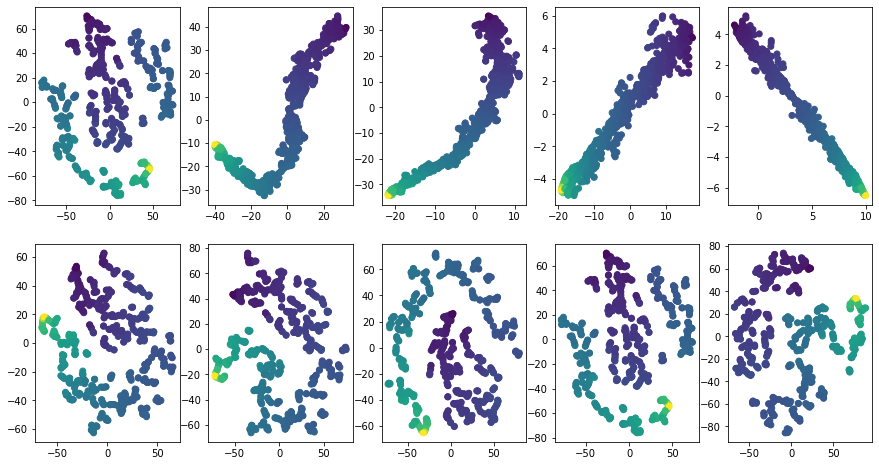

In [204]:
from sklearn import manifold
import matplotlib.pyplot as plt

float_vecs = []
preds = pred_results['predicted']
for vec in pred_results['glob_vecs']:
    float_vec = [float(x) for x in vec]
    float_vecs.append(float_vec)
    
n_samples = len(preds)

(fig, subplots) = plt.subplots(2, 5, figsize=(15, 8))

perplexities = [5, 30, 50, 100, 200]
learning_rates = [10, 50, 100, 200, 500]

for i, perplexity in enumerate(perplexities):
    ax = subplots[0][i]

    tsne = manifold.TSNE(
        n_components = 2,
        init = "random",
        random_state = 0,
        perplexity = perplexity,
        learning_rate = 200.0,
        n_iter=1000)

    Y = tsne.fit_transform(float_vecs)
   
    ax.scatter(Y[:, 0], Y[:, 1], c = pred_results['predicted'])
    
for i, learning_rate in enumerate(learning_rates):
    ax = subplots[1][i]

    tsne = manifold.TSNE(
        n_components = 2,
        init = "random",
        random_state = 0,
        perplexity = 5,
        learning_rate = learning_rate,
        n_iter=1000)

    Y = tsne.fit_transform(float_vecs)
    
    ax.scatter(Y[:, 0], Y[:, 1], c = pred_results['predicted'])

Single figures

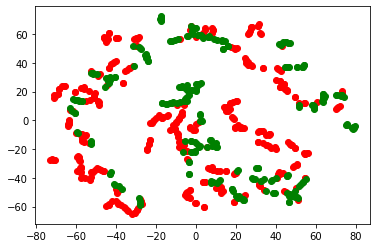

In [211]:
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure()

ax = fig.add_subplot()

tsne = manifold.TSNE(
        n_components = 2,
        init = "random",
        random_state = 0,
        perplexity = 5,
        learning_rate = 100,
        n_iter=1000)

Y = tsne.fit_transform(float_vecs)
y_true = np.array([item for item, mask in zip(Y, oxygenates) if mask])
y_false = np.array([item for item, mask in zip(Y, oxygenates) if not mask])
ax.scatter(y_true[:, 0], y_true[:, 1], c = 'r')
ax.scatter(y_false[:, 0], y_false[:, 1], c = 'g')


#ax.scatter(Y[:, 0], Y[:, 1], c = [sns.color_palette()[x] for x in range(len(cetane_range))])

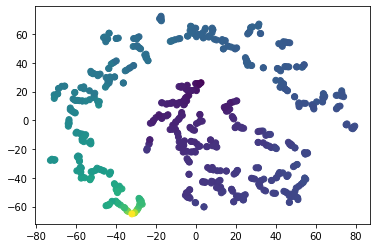

In [212]:
fig = plt.figure()

ax_2 = fig.add_subplot()
ax_2.scatter(Y[:, 0], Y[:, 1], c = pred_results['predicted'])

d = {'Canonical SMILES': pred_results['Canonical_SMILES'], 'X': Y[:, 0], 'Y': Y[:, 1]}
data_points = pd.DataFrame(d)
data_points.to_csv('fig_7.csv')